In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv("/kaggle/input/emnist/emnist-balanced-train.csv")
test_df = pd.read_csv("/kaggle/input/emnist/emnist-balanced-test.csv")

In [5]:
train_df.head()

,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.head()

,41,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.523,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532
0,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


36


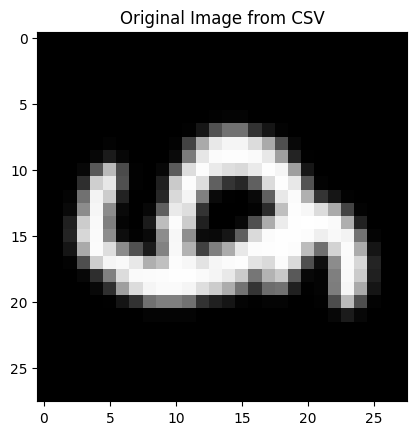

In [7]:
image_data = train_df.iloc[0, 1:].astype(float).values

image = image_data.reshape(28, 28)
label = train_df.iloc[0,0]
print(label)

plt.imshow(image, cmap="gray")
plt.title("Original Image from CSV")
plt.show()

In [8]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

In [9]:
class EMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.iloc[:, 1:].values
        self.labels = dataframe.iloc[:, 0].values
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].reshape(28, 28).astype('float32')
        label = self.labels[index]

        image = transforms.functional.to_pil_image(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [11]:
import torch
from torch.utils.data import DataLoader

train_dataset = EMNISTDataset(train_df, transform=transform_train)
test_dataset = EMNISTDataset(test_df, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)



In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 22 * 22, 128)  # Adjust based on conv3 output
        self.fc2 = nn.Linear(128, 47)
        
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

In [14]:
image, label = test_dataset[4]

print("Label:", label) 
print("Type of image:", type(image))

Label: 33
Type of image: <class 'torch.Tensor'>


In [15]:
import torchvision.transforms as transforms
to_pil = transforms.ToPILImage()
pil_sample = to_pil(image)

In [16]:
pil_sample.save("test_sample.png")

In [17]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

16897024
18874368


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

In [19]:
num_epochs = 20  # Total number of training epochs

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # force it to GPU
        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # loss function
        
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    scheduler.step()  # Adjust learning rate
    epoch_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradients computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            _ , predicted = torch.max(outputs, 1)  # Get predicted labels
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total  # Compute accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%")


Epoch [1/20], Train Loss: 2.2205
Validation Loss: 0.7786, Validation Accuracy: 77.30%
Epoch [2/20], Train Loss: 1.6381
Validation Loss: 0.6502, Validation Accuracy: 79.36%
Epoch [3/20], Train Loss: 1.4734
Validation Loss: 0.5885, Validation Accuracy: 81.23%
Epoch [4/20], Train Loss: 1.3506
Validation Loss: 0.5488, Validation Accuracy: 81.60%
Epoch [5/20], Train Loss: 1.2687
Validation Loss: 0.5146, Validation Accuracy: 83.15%
Epoch [6/20], Train Loss: 1.1997
Validation Loss: 0.4993, Validation Accuracy: 82.69%
Epoch [7/20], Train Loss: 1.1623
Validation Loss: 0.4823, Validation Accuracy: 83.99%
Epoch [8/20], Train Loss: 1.1307
Validation Loss: 0.4688, Validation Accuracy: 84.28%
Epoch [9/20], Train Loss: 1.1067
Validation Loss: 0.4673, Validation Accuracy: 84.06%
Epoch [10/20], Train Loss: 1.0873
Validation Loss: 0.4678, Validation Accuracy: 84.21%
Epoch [11/20], Train Loss: 1.0487
Validation Loss: 0.4561, Validation Accuracy: 84.63%
Epoch [12/20], Train Loss: 1.0355
Validation Loss: 0

In [20]:
torch.save(model.state_dict(), "eminst_model.pt")